In [778]:
import pandas as pd
import numpy as np
import re
from transformers import PreTrainedTokenizerFast, XLNetTokenizerFast, BertTokenizer
from os import listdir
from os.path import isfile

In [779]:
# f = open("data/Mobi-Dick-Adventure.txt", "r")
# adventure_book = f.read()
# f = open("data/pandp12p.txt", "r")
# romance = f.read()
# f = open("data/the-shining.txt", "r")
# horror = f.read()
# f = open("data/The-Martian-by-Andy-Weir-book-Sci-fi.txt", "r")
# sci_fi = f.read()
# f = open("data/Sherlock-Homes-Detective.txt", "r")
# detective = f.read()

books = {'detective': [], 'romance': [], 'sci-fi': [], 'horror': [], 'adventure': [], 'test': []}
for genre in books.keys():
    path = 'data/'+genre
    print(path)
    for book in listdir(path):
        if isfile(path+'/'+book):
            print(book)
            books[genre].append([open(path+'/'+book, 'r').read()])

data/detective
Sherlock-Homes-Detective.txt
investigates _detective.txt
data/romance
anna_romance.txt
pandp12p.txt
data/sci-fi
The-Martian-by-Andy-Weir-book-Sci-fi.txt
stars_sci_fi.txt
data/horror
jaws_horror.txt
auctioneer_horro.txt
the-shining.txt
data/adventure
donq_adventure.txt
Mobi-Dick-Adventure.txt
data/test
15_year_old_captain.txt
three_mush.txt
The Master and Margarita.txt


In [780]:
len(books['detective'])

2

In [781]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("\n","  ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences


def get_paragraphs(book, genre, book_indx):
    book_sentences = split_into_sentences(book)
    # print(len(book_sentences))
    book_sentences = book_sentences[int(len(book_sentences)*0.1) : int(len(book_sentences)*0.9)]
    # print(len(book_sentences))
    paragraphs = []
    genres = []
    book_indxs = []
    for indx in range(1, int(len(book_sentences)/10)):
        paragraphs.append(' '.join(book_sentences[(indx-1)*10 : indx*10]))
        genres.append(genre)
        book_indxs.append(book_indx)
    return paragraphs, genres, book_indxs

paragraphs = []
genres = []
book_indxs = []
for genre in books.keys():
    for indx, book in enumerate(books[genre]):
        paragraph, genre_l, book_indx = get_paragraphs(book[0], genre, indx)
        print(len(genre_l[0]))
        paragraphs= paragraphs + paragraph[:500]
        genres = genres + genre_l[:500]
        book_indxs = book_indxs + book_indx[:500]

data = pd.DataFrame({'paragraph': paragraphs, 'genre': genres, 'book': book_indxs})

9
9
7
7
6
6
6
6
6
9
9
4
4
4


In [782]:
data

,paragraph,genre,book
0,“Then I can wait in the next room”. “Not at al...,detective,0
1,"“You did, Doctor, but none the less you must c...",detective,0
2,"I did not gain very much, however, by my inspe...",detective,0
3,"“How did you know, for example, that I did man...",detective,0
4,"” “Well, but China? ” “The fish that you hav...",detective,0
...,...,...,...
6149,And generally I will allow myself the boldness...,test,2
6150,There are things in which neither barriers of ...,test,2
6151,In these seven golden claws' burned thick wax ...,test,2
6152,"Hella rose and bowed to Margarita. The cat, ju...",test,2


In [783]:
data['genre'].value_counts()

test         1500
sci-fi       1000
adventure    1000
romance       978
detective     906
horror        770
Name: genre, dtype: int64

In [784]:
data.to_csv('paragraphs.csv')

In [785]:
data['genre'].value_counts()

test         1500
sci-fi       1000
adventure    1000
romance       978
detective     906
horror        770
Name: genre, dtype: int64

In [786]:
X = data.drop(data[data['genre'] == 'test'].index)
y = data[data['genre'] == 'test']

In [787]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_text = [[]]
encoded_y = [[]]
for text in X['paragraph']:
    encoded_text.append(tokenizer.encode(text, padding='max_length', max_length=639,  truncation=True, return_tensors='np'))

for text in y['paragraph']:
    encoded_y.append(tokenizer.encode(text, padding='max_length', max_length=639,  truncation=True, return_tensors='np'))


In [788]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_vectors = vectorizer.fit_transform(X['paragraph'])
y_vectors = vectorizer.transform(y['paragraph'])

In [789]:
encoded_text_np = np.array(encoded_text[1:])
encoded_y_np = np.array(encoded_y[1:])

In [790]:
encoded_text_np = np.squeeze(encoded_text_np, axis=1)
encoded_y_np = np.squeeze(encoded_y_np, axis=1)

In [791]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(encoded_text_np)
y['cluster'] = kmeans.predict(encoded_y_np)

<ipython-input-791-a8a21019db28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster'] = kmeans.predict(encoded_y_np)


In [792]:
kmeans_tf_idf = KMeans(n_clusters=5, random_state=0).fit(X_vectors)
y['cluster_tf_idf'] = kmeans_tf_idf.predict(y_vectors)

<ipython-input-792-1673ab96c585>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster_tf_idf'] = kmeans_tf_idf.predict(y_vectors)


In [793]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 423, 1: 1236, 2: 877, 3: 624, 4: 1494}

In [794]:
X['cluster'] = kmeans.labels_

In [795]:
X['cluster_tf_idf'] = kmeans_tf_idf.labels_

In [796]:

cluster_assigning = ['', '', '', '', '']
for cluster in range(5):
    genre_occurence = {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 0}
    for genre in X[X['cluster'] == cluster]['genre']:
        genre_occurence[genre] = genre_occurence[genre] + 1
    print(genre_occurence)
    cluster_assigning[cluster] = max(genre_occurence, key=genre_occurence.get)

cluster_assigning

{'detective': 0, 'romance': 18, 'sci-fi': 0, 'horror': 8, 'adventure': 397}
{'detective': 359, 'romance': 297, 'sci-fi': 282, 'horror': 203, 'adventure': 95}
{'detective': 203, 'romance': 331, 'sci-fi': 36, 'horror': 140, 'adventure': 167}
{'detective': 36, 'romance': 203, 'sci-fi': 1, 'horror': 102, 'adventure': 282}
{'detective': 308, 'romance': 129, 'sci-fi': 681, 'horror': 317, 'adventure': 59}


['adventure', 'detective', 'romance', 'adventure', 'sci-fi']

In [797]:
y['cluster'].value_counts()

1    597
2    519
4    272
3    109
0      3
Name: cluster, dtype: int64

In [798]:
cluster_assigning_ = ['', '', '', '', '']
for cluster in range(5):
    genre_occurence_ = {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 0}
    for genre in X[X['cluster_tf_idf'] == cluster]['genre']:
        genre_occurence_[genre] = genre_occurence_[genre] + 1
    print(genre_occurence_)
    cluster_assigning_[cluster] = max(genre_occurence_, key=genre_occurence_.get)

cluster_assigning_

{'detective': 491, 'romance': 203, 'sci-fi': 178, 'horror': 244, 'adventure': 377}
{'detective': 356, 'romance': 226, 'sci-fi': 809, 'horror': 331, 'adventure': 136}
{'detective': 57, 'romance': 537, 'sci-fi': 13, 'horror': 38, 'adventure': 25}
{'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 157, 'adventure': 0}
{'detective': 2, 'romance': 12, 'sci-fi': 0, 'horror': 0, 'adventure': 462}


['detective', 'sci-fi', 'romance', 'horror', 'adventure']

In [799]:
y['cluster_tf_idf'].value_counts()

0    947
1    465
2     79
4      9
Name: cluster_tf_idf, dtype: int64

In [800]:
X[X['cluster_tf_idf'] == 3]

,paragraph,genre,book,cluster,cluster_tf_idf
2979,Any overbid of an adversary shows strength; an...,horror,1,2,3
2980,"If it be 3 or more, Royals, with a holding of ...",horror,1,2,3
2981,In all cases where the score is not especially...,horror,1,3,3
2982,THE BID OF ONE NO-TRUMP The Dealer is justifi...,horror,1,2,3
2983,"Knave, Ten, and two others surely stops a suit...",horror,1,1,3
...,...,...,...,...,...
3149,The rule clearly decides this case. The advers...,horror,1,0,3
3150,"Seven Diamonds, headed by Knave, Ten; Ace of S...",horror,1,1,3
3151,It cannot affect the confidence of the partner...,horror,1,2,3
3152,"2. Three, or even Four, Diamonds. (The bid of ...",horror,1,1,3


In [801]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() #create dataframe, rows: clusters, columns: words

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]])) #sort words for every cluster and print top 10

get_top_keywords(X_vectors, X['cluster_tf_idf'], vectorizer.get_feature_names_out(), 5)


Cluster 0
he,to,of,and,the

Cluster 1
and,it,to,you,the

Cluster 2
to,and,the,she,her

Cluster 3
of,partner,is,suit,the

Cluster 4
that,of,to,and,the


In [802]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonibekmansurov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [803]:
mispell_dict = {"ain’t": "is not", "aren’t": "are not","can’t": "cannot",
                "’cause": "because", "could’ve": "could have", "couldn’t":
                "could not", "didn’t": "did not",  "doesn’t": "does not",
                "don’t": "do not", "hadn’t": "had not", "hasn’t": "has not",
                "haven’t": "have not", "he’d": "he would","he’ll": "he will",
                "he’s": "he is", "how’d": "how did", "how’d’y": "how do you",
                "how’ll": "how will", "how’s": "how is",  "I’d": "I would",
                "I’d’ve": "I would have", "I’ll": "I will", "I’ll’ve": "I will have",
                "I’m": "I am", "I’ve": "I have", "i’d": "i would",
                "i’d’ve": "i would have", "i’ll": "i will",
                "i’ll’ve": "i will have","i’m": "i am", "i’ve": "i have",
                "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
                "it’ll": "it will", "it’ll’ve": "it will have","it’s": "it is",
                "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
                "might’ve": "might have","mightn’t": "might not",
                "mightn’t’ve": "might not have", "must’ve": "must have",
                "mustn’t": "must not", "mustn’t’ve": "must not have",
                "needn’t": "need not", "needn’t’ve": "need not have",
                "o’clock": "of the clock", "oughtn’t": "ought not",
                "oughtn’t’ve": "ought not have", "shan’t": "shall not",
                "sha’n’t": "shall not", "shan’t’ve": "shall not have",
                "she’d": "she would", "she’d’ve": "she would have", "she’ll":
                    "she will", "she’ll’ve": "she will have", "she’s": "she is",
                "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
                "so’ve": "so have","so’s": "so as", "this’s": "this is","that’d": "that would",
                "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
                "there’d’ve": "there would have", "there’s": "there is", "here’s": "here is",
                "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
                "they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have",
                "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
                "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have",
                "weren’t": "were not", "what’ll": "what will", "what’ll’ve": "what will have",
                "what’re": "what are",  "what’s": "what is", "what’ve": "what have", "when’s":
                    "when is", "when’ve": "when have", "where’d": "where did", "where’s": "where is",
                "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
                "who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have",
                "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
                "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
                "y’all": "you all", "y’all’d": "you all would","y’all’d’ve": "you all would have",
                "y’all’re": "you all are","y’all’ve": "you all have","you’d": "you would", "you’d’ve": "you would have",
                "you’ll": "you will", "you’ll’ve": "you will have", "you’re": "you are", "you’ve": "you have", "she`s": "she is", "\n": " ", "  ": " "}

In [804]:
# import spacy
# from spacy import displacy

# NER = spacy.load("en_core_web_sm")
# ner_list = ['PERSON', 'ORG']

def preprocess_paragraph(data):
    stop_words = set(stopwords.words('english'))
    preprocessed_paragraphs = []
    for paragraph in data:
        punctuation = string.punctuation
        punctuation = punctuation + '“”’,‘'
        # paragraph_ner = NER(paragraph)
        # ner_words = [word.text for word in paragraph_ner.ents if word.label_ in ner_list]
        # paragraph = " ".join([word for word in paragraph.split() if word not in ner_words])
        paragraph = " ".join([word for word in paragraph.split() if word[0].islower()])
        paragraph = paragraph.lower()
        for key in mispell_dict.keys():
            paragraph = paragraph.replace(key, mispell_dict[key])
        paragraph = paragraph.translate(str.maketrans('', '', punctuation))
        word_tokens = word_tokenize(paragraph)
        filtered_sentence = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)
        preprocessed_paragraphs.append(' '.join(filtered_sentence))

    return preprocessed_paragraphs

In [805]:
X['preprocessed_paragraphs'] = preprocess_paragraph(X['paragraph'])
y['preprocessed_paragraphs'] = preprocess_paragraph(y['paragraph'])

<ipython-input-805-ef58512964a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['preprocessed_paragraphs'] = preprocess_paragraph(y['paragraph'])


In [806]:
X.to_csv('preprocessed.csv')
y.to_csv('preprocessed_test.csv')


In [807]:
X

,paragraph,genre,book,cluster,cluster_tf_idf,preprocessed_paragraphs
0,“Then I can wait in the next room”. “Not at al...,detective,0,2,0,wait next room gentleman partner helper many s...
1,"“You did, Doctor, but none the less you must c...",detective,0,3,0,none less must come round view otherwise shall...
2,"I did not gain very much, however, by my inspe...",detective,0,2,0,gain much however inspection visitor bore ever...
3,"“How did you know, for example, that I did man...",detective,0,1,1,know example manual labour true gospel began s...
4,"” “Well, but China? ” “The fish that you hav...",detective,0,1,1,fish tattooed immediately right wrist could do...
...,...,...,...,...,...,...
4649,"Do I smell ginger? ” suspiciously asked Stubb,...",adventure,1,4,1,smell ginger suspiciously asked coming near mu...
4650,Sea-coal? firewood? —lucifer matches? —tinder?...,adventure,1,1,1,firewood matches devil ginger say offer cup po...
4651,and may I ask whether this is the sort of bitt...,adventure,1,2,1,may ask whether sort bitters blows back life h...
4652,It is the captain’s orders—grog for the harpoo...,adventure,1,2,0,captains orders—grog harpooneer whale replied ...


In [808]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_pr = vectorizer.fit_transform(X['preprocessed_paragraphs'])
y_pr = vectorizer.transform(y['preprocessed_paragraphs'])

In [809]:
n_clusters = 13
kmeans_tf_idf_pr = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pr)
y['cluster_tf_idf_pr'] = kmeans_tf_idf_pr.predict(y_pr)

<ipython-input-809-37c1a7ff6348>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster_tf_idf_pr'] = kmeans_tf_idf_pr.predict(y_pr)


In [810]:
X['cluster_tf_idf_pr'] = kmeans_tf_idf_pr.labels_

In [811]:
cluster_assigning_pr = ['' for x in range(n_clusters)]
for cluster in range(n_clusters):
    genre_occurence_ = {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 0}
    for genre in X[X['cluster_tf_idf_pr'] == cluster]['genre']:
        genre_occurence_[genre] = genre_occurence_[genre] + 1
    print(f'{cluster}: {genre_occurence_}')
    cluster_assigning_pr[cluster] = max(genre_occurence_, key=genre_occurence_.get)
print()
for indx, cluster in enumerate(cluster_assigning_pr):
    print(f'{indx}: {cluster}')

0: {'detective': 129, 'romance': 26, 'sci-fi': 376, 'horror': 64, 'adventure': 64}
1: {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 148}
2: {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 146, 'adventure': 0}
3: {'detective': 0, 'romance': 0, 'sci-fi': 336, 'horror': 0, 'adventure': 0}
4: {'detective': 71, 'romance': 137, 'sci-fi': 117, 'horror': 110, 'adventure': 27}
5: {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 15, 'adventure': 69}
6: {'detective': 3, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 265}
7: {'detective': 87, 'romance': 285, 'sci-fi': 16, 'horror': 121, 'adventure': 14}
8: {'detective': 0, 'romance': 0, 'sci-fi': 54, 'horror': 120, 'adventure': 0}
9: {'detective': 0, 'romance': 0, 'sci-fi': 0, 'horror': 0, 'adventure': 319}
10: {'detective': 279, 'romance': 22, 'sci-fi': 4, 'horror': 48, 'adventure': 69}
11: {'detective': 42, 'romance': 456, 'sci-fi': 0, 'horror': 0, 'adventure': 2}
12: {'detective': 295, 'romance': 52, 'sc

In [812]:
y[y['book'] == 0]['cluster_tf_idf_pr'].value_counts()

0     164
10    121
7      78
6      57
4      32
12     28
11     19
9       1
Name: cluster_tf_idf_pr, dtype: int64

In [813]:
y[y['book'] == 1]['cluster_tf_idf_pr'].value_counts()

10    129
0     112
12    100
4      85
11     45
7      22
9       7
Name: cluster_tf_idf_pr, dtype: int64

In [814]:
y[y['book'] == 2]['cluster_tf_idf_pr'].value_counts()

12    214
0     154
7      69
10     25
4      19
8      18
11      1
Name: cluster_tf_idf_pr, dtype: int64

In [815]:
len(set(cluster_assigning_pr))

5

In [816]:
get_top_keywords(X_pr, X['cluster_tf_idf_pr'], vectorizer.get_feature_names_out(), n_clusters)


Cluster 0
right,cant,cried,face,could,way,said,youre,know,like,man,us,got

Cluster 1
would,may,us,replied,hast,see,say,art,worship,said,thy,thee,thou

Cluster 2
may,tricks,player,one,game,hand,cards,two,strength,partner,declaration,bid,suit

Cluster 3
mission,days,solar,said,back,would,need,suit,time,wil,get,rover,al

Cluster 4
us,say,got,want,looked,one,go,think,like,going,know,asked,said

Cluster 5
cried,surface,us,three,cage,old,pull,men,said,harpoon,boat,shark,ye

Cluster 6
boats,ships,man,yet,though,like,boat,one,upon,sea,whales,ship,whale

Cluster 7
felt,come,time,one,came,thought,back,go,away,went,said,could,would

Cluster 8
got,cant,beaches,shark,looked,boat,boy,fish,think,want,know,said,dont

Cluster 9
great,know,made,us,may,good,say,without,master,curate,one,would,said

Cluster 10
see,said,case,think,old,little,must,shall,may,would,one,man,upon

Cluster 11
every,father,family,think,never,soon,said,know,sister,much,must,would,could

Cluster 12
upon,see,like,hand,little,head,l

In [817]:
len(X[(X['genre'] == 'horror') & (X['book'] == 1) & ((X['cluster_tf_idf_pr'] == 0))])

3

In [818]:
data

,paragraph,genre,book
0,“Then I can wait in the next room”. “Not at al...,detective,0
1,"“You did, Doctor, but none the less you must c...",detective,0
2,"I did not gain very much, however, by my inspe...",detective,0
3,"“How did you know, for example, that I did man...",detective,0
4,"” “Well, but China? ” “The fish that you hav...",detective,0
...,...,...,...
6149,And generally I will allow myself the boldness...,test,2
6150,There are things in which neither barriers of ...,test,2
6151,In these seven golden claws' burned thick wax ...,test,2
6152,"Hella rose and bowed to Margarita. The cat, ju...",test,2


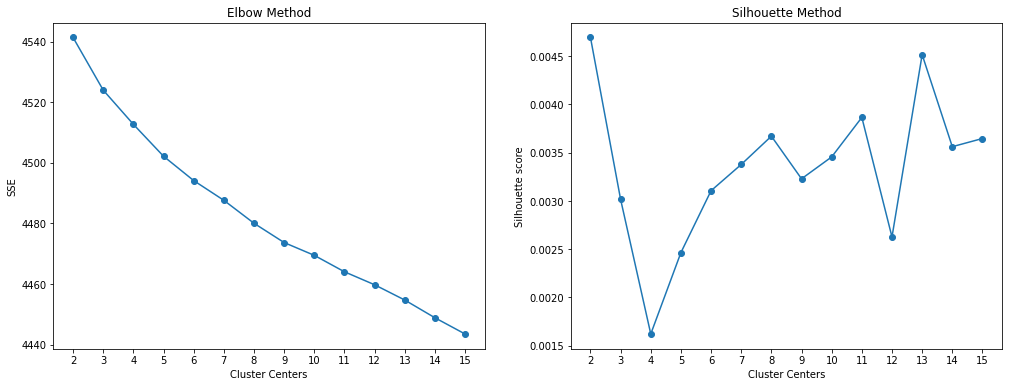

In [819]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)

    sse = []
    sil = []
    for k in iters:
        clusters = KMeans(n_clusters=k, random_state=5).fit(data)
        sse.append(clusters.inertia_) #get sse for every cluster for elbow method
        sil.append(silhouette_score(data, clusters.labels_, metric = 'euclidean')) #get Silhouette score for Silhouette method

    f, ax = plt.subplots(1, 2, figsize=(17, 6))

    #plot results of Elbow method
    ax[0].plot(iters, sse, marker='o')
    ax[0].set_xlabel('Cluster Centers')
    ax[0].set_xticks(iters)
    ax[0].set_xticklabels(iters)
    ax[0].set_ylabel('SSE')
    ax[0].set_title('Elbow Method')

    #plot results of Silhouette method
    ax[1].plot(iters, sil, marker='o')
    ax[1].set_xlabel('Cluster Centers')
    ax[1].set_xticks(iters)
    ax[1].set_xticklabels(iters)
    ax[1].set_ylabel('Silhouette score')
    ax[1].set_title('Silhouette Method')

find_optimal_clusters(X_pr, 15)

In [820]:
y

,paragraph,genre,book,cluster,cluster_tf_idf,preprocessed_paragraphs,cluster_tf_idf_pr
4654,"""Well, Mr. Benedict,"" retorted Captain Hull, ""...",test,0,1,1,retorted said long entomologist asked quickly ...,4
4655,"""I believe so, indeed,"" retorted Captain Hull,...",test,0,3,0,believe indeed retorted gravely never existed ...,7
4656,But the colossal pupil listened so quietly to ...,test,0,2,0,colossal pupil listened quietly professors les...,10
4657,"It was on the morning of February 9th, Jack, h...",test,0,2,0,morning halflying deck amusing forming word ol...,7
4658,"But Dingo had returned, and, beginning the sam...",test,0,1,0,returned beginning performance seized another ...,12
...,...,...,...,...,...,...,...
6149,And generally I will allow myself the boldness...,test,2,2,0,generally allow boldness advising never afraid...,10
6150,There are things in which neither barriers of ...,test,2,2,0,things neither barriers rank even borders coun...,12
6151,In these seven golden claws' burned thick wax ...,test,2,2,0,seven golden claws burned thick wax candles ta...,12
6152,"Hella rose and bowed to Margarita. The cat, ju...",test,2,2,0,rose bowed cat jumping tabouret likewise right...,12


In [867]:
X[(X['genre'] == 'adventure') & ((X['cluster_tf_idf_pr'] == 1))].reset_index()

,index,paragraph,genre,book,cluster,cluster_tf_idf,preprocessed_paragraphs,cluster_tf_idf_pr
0,3655,"Not so did Sancho Panza spend it, for having h...",adventure,0,0,4,spend stomach full something stronger chicory ...,1
1,3657,"Sancho Panza, when he saw the friar on the gro...",adventure,0,0,4,saw friar ground dismounting briskly ass rushe...,1
2,3663,"To which Don Quixote replied, “Thou must take ...",adventure,0,0,4,replied must take notice brother adventure lik...,1
3,3664,“What vial and what balsam is that? ” said San...,adventure,0,0,4,vial balsam said balsam answered receipt memor...,1
4,3665,"Hearing this, Sancho said to him, “Your worshi...",adventure,0,0,4,said worship bear mind knight done commanded g...,1
...,...,...,...,...,...,...,...,...
143,4236,"However, it is always as well to have a look a...",adventure,1,1,1,always well look irrevocably committing hands ...,1
144,4254,“I don’t know anything about Deacon Deuteronom...,adventure,1,2,1,know anything meeting said know born member de...,1
145,4258,"He got so frightened about his plaguy soul, th...",adventure,1,2,0,got frightened plaguy soul shrinked sheered aw...,1
146,4384,art not game for Moby Dick? ” “I am game for ...,adventure,1,2,1,art game game crooked jaw jaws fairly comes wa...,1


In [866]:
X[(X['genre'] == 'detective') & ((X['cluster_tf_idf_pr'] == 12))].iloc[19]['paragraph']

'He picked out from his bundle a copy of the local Herefordshire paper, and having turned down the sheet he pointed out the paragraph in which the unfortunate young man had given his own statement of what had occurred. I settled myself down in the corner of the carriage and read it very carefully. It ran in this way:  “Mr. James McCarthy, the only son of the deceased, was then called and gave evidence as follows: ‘I had been away from home for three days at Bristol, and had only just returned upon the morning of last Monday, the 3rd. My father was absent from home at the time of my arrival, and I was informed by the maid that he had driven over to Ross with John Cobb, the groom. Shortly after my return I heard the wheels of his trap in the yard, and, looking out of my window, I saw him get out and walk rapidly out of the yard, though I was not aware in which direction he was going. I then took my gun and strolled out in the direction of the Boscombe Pool, with the intention of visiting

In [872]:
y[(y['book'] == 0) & ((y['cluster_tf_idf_pr'] == 6))].reset_index()

,index,paragraph,genre,book,cluster,cluster_tf_idf,preprocessed_paragraphs,cluster_tf_idf_pr
0,4673,"On the ""Pilgrim,"" which peculiar circumstances...",test,0,2,0,peculiar circumstances obliged leave fishing g...,6
1,4674,"Besides, life always manifests itself above as...",test,0,3,0,life always manifests well seas passengers cou...,6
2,4678,"Do you see, Mrs. Weldon, when we whalers, duri...",test,0,2,0,see whalers fishing season arrive sight shoal ...,6
3,4679,"""You think right, Jack,"" observed Dick Sand, ""...",test,0,2,0,think right observed lose time picking crustac...,6
4,4680,Whalers could not be mistaken in it. But the d...,test,0,3,0,could mistaken distance still considerable mak...,6
5,4681,"The hunters of large game, they say, are more ...",test,0,1,0,hunters large game say eager hunters small gam...,6
6,4683,"""Yes, my boy! and when we think that the great...",test,0,1,0,boy think great beast process breakfasting lit...,6
7,4685,"said one of the sailors, ""a fine jubarte is al...",test,0,1,0,said one sailors fine jubarte fine capture pro...,6
8,4686,"""Mama, mama""! then cried little Jack, ""I shoul...",test,0,4,1,mama cried little like whale see made wish wha...,6
9,4687,"""This will not be the first time that I have f...",test,0,4,0,first time followed trade harpooner added see ...,6


In [874]:
y[(y['book'] == 0) & ((y['cluster_tf_idf_pr'] == 6))].iloc[4]['paragraph']

'Whalers could not be mistaken in it. But the distance was still too considerable to make it possible to recognize the species to which this mammifer belonged. These species, in fact, are quite distinct. Was it one of those "right" whales, which the fishermen of the Northern Ocean seek most particularly? Those cetaceans, which lack the dorsal fin, but whose skin covers a thick stratum of lard, may attain a length of eighty feet, though the average does not exceed sixty, and then a single one of those monsters furnishes as much as a hundred barrels of oil. Was it, on the contrary, a "humpback," belonging to the species of baloenopters, a designation whose termination should at least gain it the entomologist\'s esteem? These possess dorsal fins, white in color, and as long as half the body, which resemble a pair of wings--something like a flying whale. Had they not in view, more likely, a "finback" mammifer, as well known by the name "jubarte," which is provided with a dorsal fin, and wh